In [4]:
#!pip install -r requirements.txt

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.gofplots import qqplot
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


## Read data from files
kodiak = pd.read_csv('data/kodiak.txt', sep="\s+", names=["Latitude","Longitude"])
dstns = pd.read_csv('data/dstns.txt', sep="\s+", names=["Year","Length","Females_juveniles","Females_Adult","Males"])
fleet = pd.read_csv('data/fleet.txt', sep="\s+", names=["Year","Vessels_register_fishing","Crab_catch","Weight_crab_catch","pot_lifts","Price_crab"])
fullness = pd.read_csv('data/fullness.txt', sep="\s+", names=["Year","Size","0%_fullness","1-29%_fullness","30-59%_fullness","60-89%_fullness","90-100%_fullness"])
survey = pd.read_csv('data/survey.txt', sep="\s+", names=["annee","district","station","pots","latitude","longitude","pre4","pre3","pre2","pre1","rmale","prmale","juvfemale","adultfemale"])
eggs = pd.read_csv('data/eggs.txt', sep="\s+", names=["annee","Nboeufs"])
celsius = pd.read_csv('data/celsius.txt', sep="\s+", names=["annee","mois","temp"])
catch = pd.read_csv('data/catch.txt', sep="\s+", names=["annee","district","Nbcapture","Nbcapturekg"])
salinite = pd.read_csv('data/salinity.txt', sep="\s+", names=["annee","mois","salinite"])

In [6]:
## Data manipulations

fleet["Meankg"] = fleet["Weight_crab_catch"] / fleet["Crab_catch"]
fleet["logprice"] = np.log(fleet["Price_crab"])


survey['price'] = survey['annee'].map(fleet.set_index('Year')['Price_crab'])
survey["legal_male"] = survey["rmale"] + survey["prmale"]
survey["all_male"] = survey[["pre4","pre3","pre2","pre1","rmale","prmale"]].sum(axis=1)
survey["all_female"] = survey["juvfemale"] + survey["adultfemale"]
survey["sexratio"] = survey["all_female"] / survey["all_male"]
survey["sexratio"].replace({0: np.nan, "NaN": np.nan, "Inf": np.nan}, inplace=True)

meanTemp = celsius.groupby('annee').temp.mean().reset_index()
eggs['temp'] = eggs["annee"].map(meanTemp.set_index('annee')['temp'])

merged_df = pd.merge(catch, fleet[['Year', 'Price_crab', 'Vessels_register_fishing', 'pot_lifts']], left_on='annee', right_on='Year', how='left')
catch['Price'] = merged_df['Price_crab']
catch['vessels'] = merged_df['Vessels_register_fishing']
catch['pieges'] = merged_df['pot_lifts']
catch["vessels"] = catch['annee'].map(fleet.set_index('Year')['Vessels_register_fishing'])
catch["pieges"] = catch['annee'].map(fleet.set_index('Year')['pot_lifts'])

catch["Pricekg"] = catch["Price"] / 0.45
catch["PoidsCrabs"] = catch["Nbcapturekg"] / catch["Nbcapture"]
catch["Meanprice1crab"] = catch["PoidsCrabs"] * catch["Pricekg"]

meansalinity = salinite.groupby('annee').salinite.mean().reset_index()
eggs['salinity'] = eggs["annee"].map(meansalinity.set_index('annee')['salinite'])


<function matplotlib.pyplot.show(close=None, block=None)>

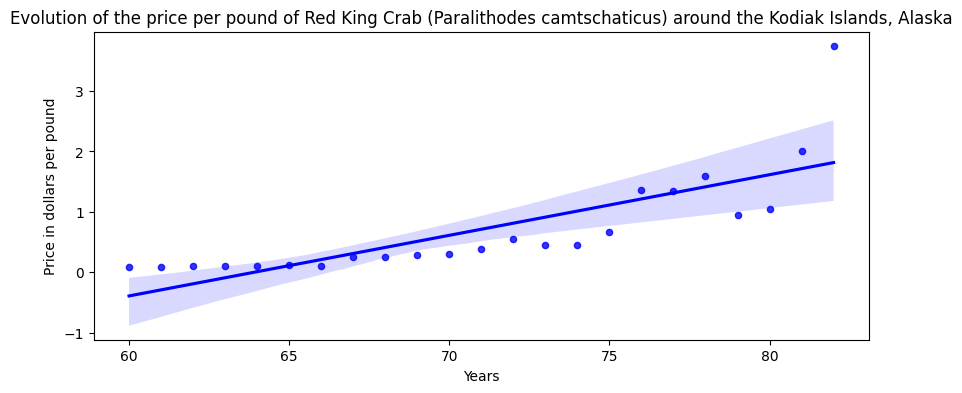

In [7]:
# Figure 2: Price as a function of years, Plot + 95% confidence interval
plt.figure(figsize=(10, 4))
sns.regplot(data=fleet, x='Year', y='Price_crab', color='#0000FF', scatter_kws={'s':20})
plt.title("Evolution of the price per pound of Red King Crab (Paralithodes camtschaticus) around the Kodiak Islands, Alaska")
plt.xlabel("Years")
plt.ylabel("Price in dollars per pound")
plt.show

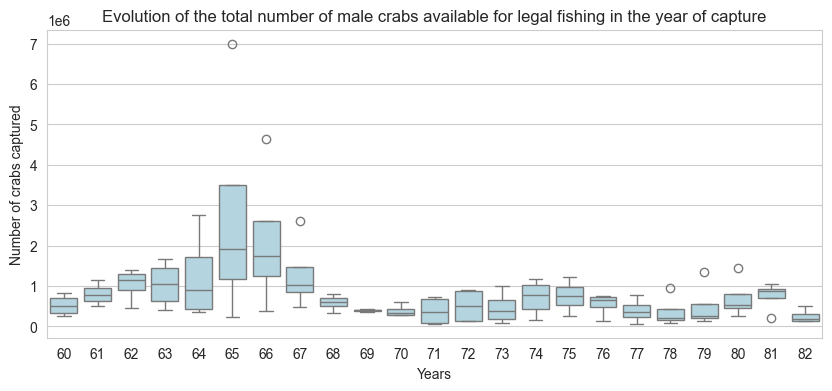

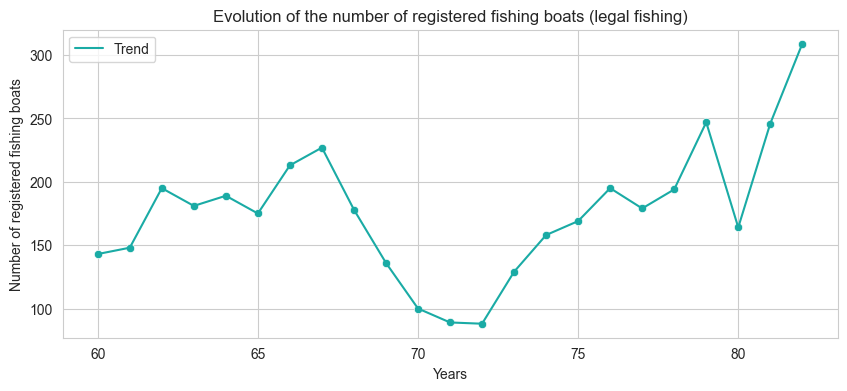

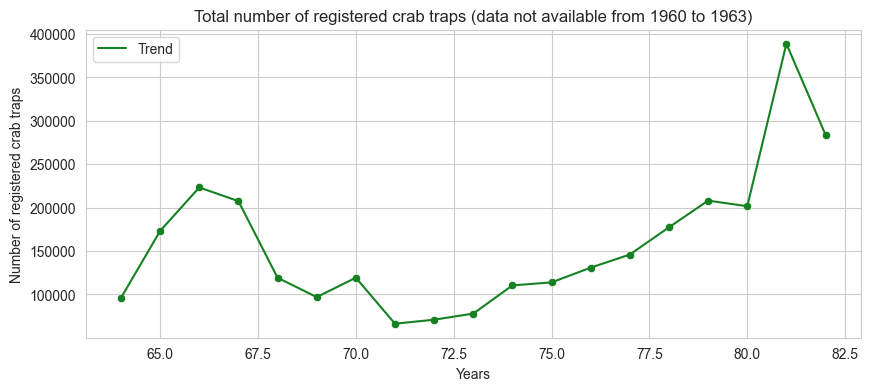

In [8]:
sns.set_style("whitegrid")

# Figure 3: Number of catches over time
plt.figure(figsize=(10, 4))
sns.boxplot(data=catch, x='annee', y='Nbcapture', color='lightblue')
plt.title("Evolution of the total number of male crabs available for legal fishing in the year of capture")
plt.xlabel("Years")
plt.ylabel("Number of crabs captured")
plt.show()

# Figure 4: Number of fishing boats
plt.figure(figsize=(10, 4))
sns.lineplot(data=fleet, x='Year', y='Vessels_register_fishing', color="#1AABA5", label="Trend")
sns.scatterplot(data=fleet, x='Year', y='Vessels_register_fishing', color="#1AABA5")
plt.title("Evolution of the number of registered fishing boats (legal fishing)")
plt.xlabel("Years")
plt.ylabel("Number of registered fishing boats")
plt.show()

# Figure 5: Number of traps
plt.figure(figsize=(10, 4))
sns.lineplot(data=fleet, x='Year', y='pot_lifts', color="#158122", label="Trend")
sns.scatterplot(data=fleet, x='Year', y='pot_lifts', color="#158122")
plt.title("Total number of registered crab traps (data not available from 1960 to 1963)")
plt.xlabel("Years")
plt.ylabel("Number of registered crab traps")
plt.show()


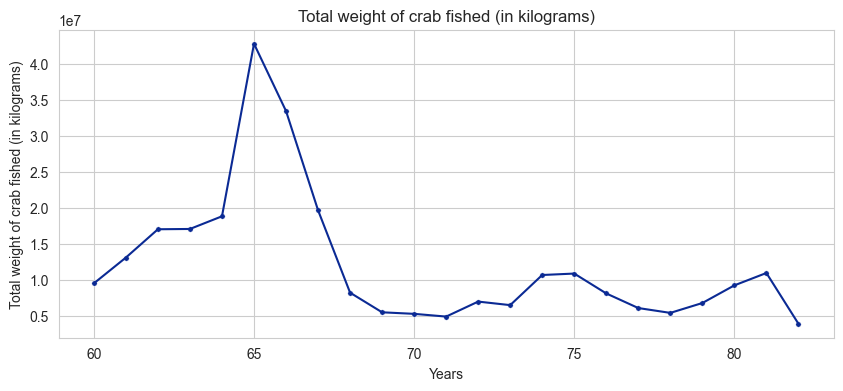

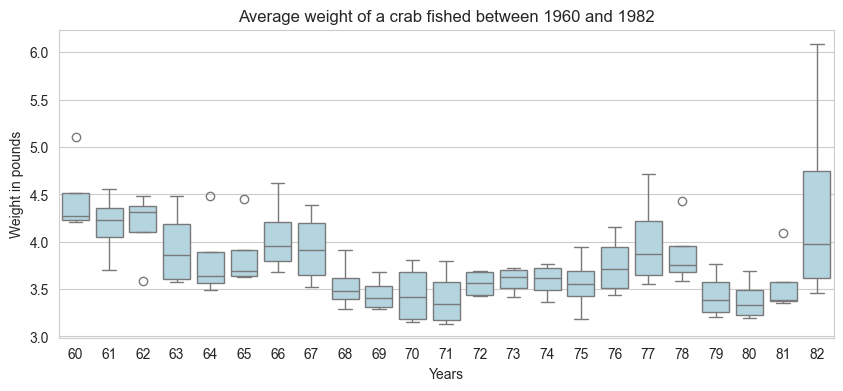

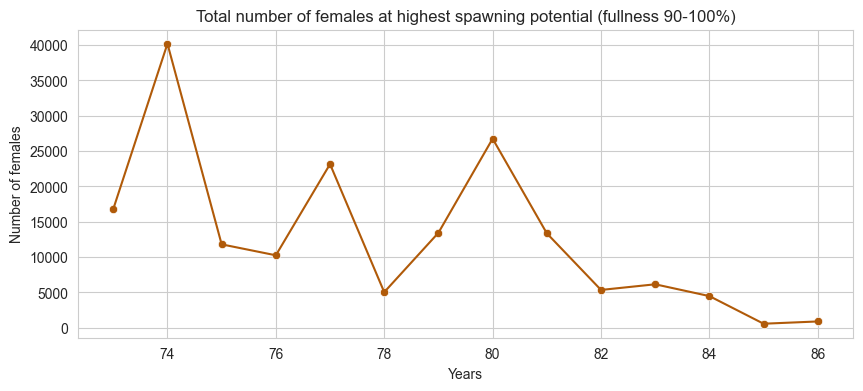

In [9]:
# Figure 6: Total weight of catches
plt.figure(figsize=(10, 4))
sns.lineplot(data=fleet, x='Year', y='Weight_crab_catch', color="#0B2A94")
sns.scatterplot(data=fleet, x='Year', y='Weight_crab_catch', color="#0B2A94", s=15)
plt.title("Total weight of crab fished (in kilograms)")
plt.xlabel("Years")
plt.ylabel("Total weight of crab fished (in kilograms)")
plt.show()

# Figure 7: Average weight of crabs
plt.figure(figsize=(10, 4))
sns.boxplot(data=catch, x='annee', y='PoidsCrabs', color='lightblue')
plt.title("Average weight of a crab fished between 1960 and 1982")
plt.xlabel("Years")
plt.ylabel("Weight in pounds")
plt.show()

# Figure 8: Fullness females 100%
fullness_years = fullness.groupby('Year').agg({'90-100%_fullness':'sum'}).reset_index()
plt.figure(figsize=(10, 4))
sns.lineplot(data = fullness_years, x = "Year", y ='90-100%_fullness', color="#B05A09")
sns.scatterplot(data=fullness_years, x='Year', y='90-100%_fullness', color="#B05A09")
plt.title("Total number of females at highest spawning potential (fullness 90-100%)")
plt.xlabel("Years")
plt.ylabel("Number of females")
plt.show()

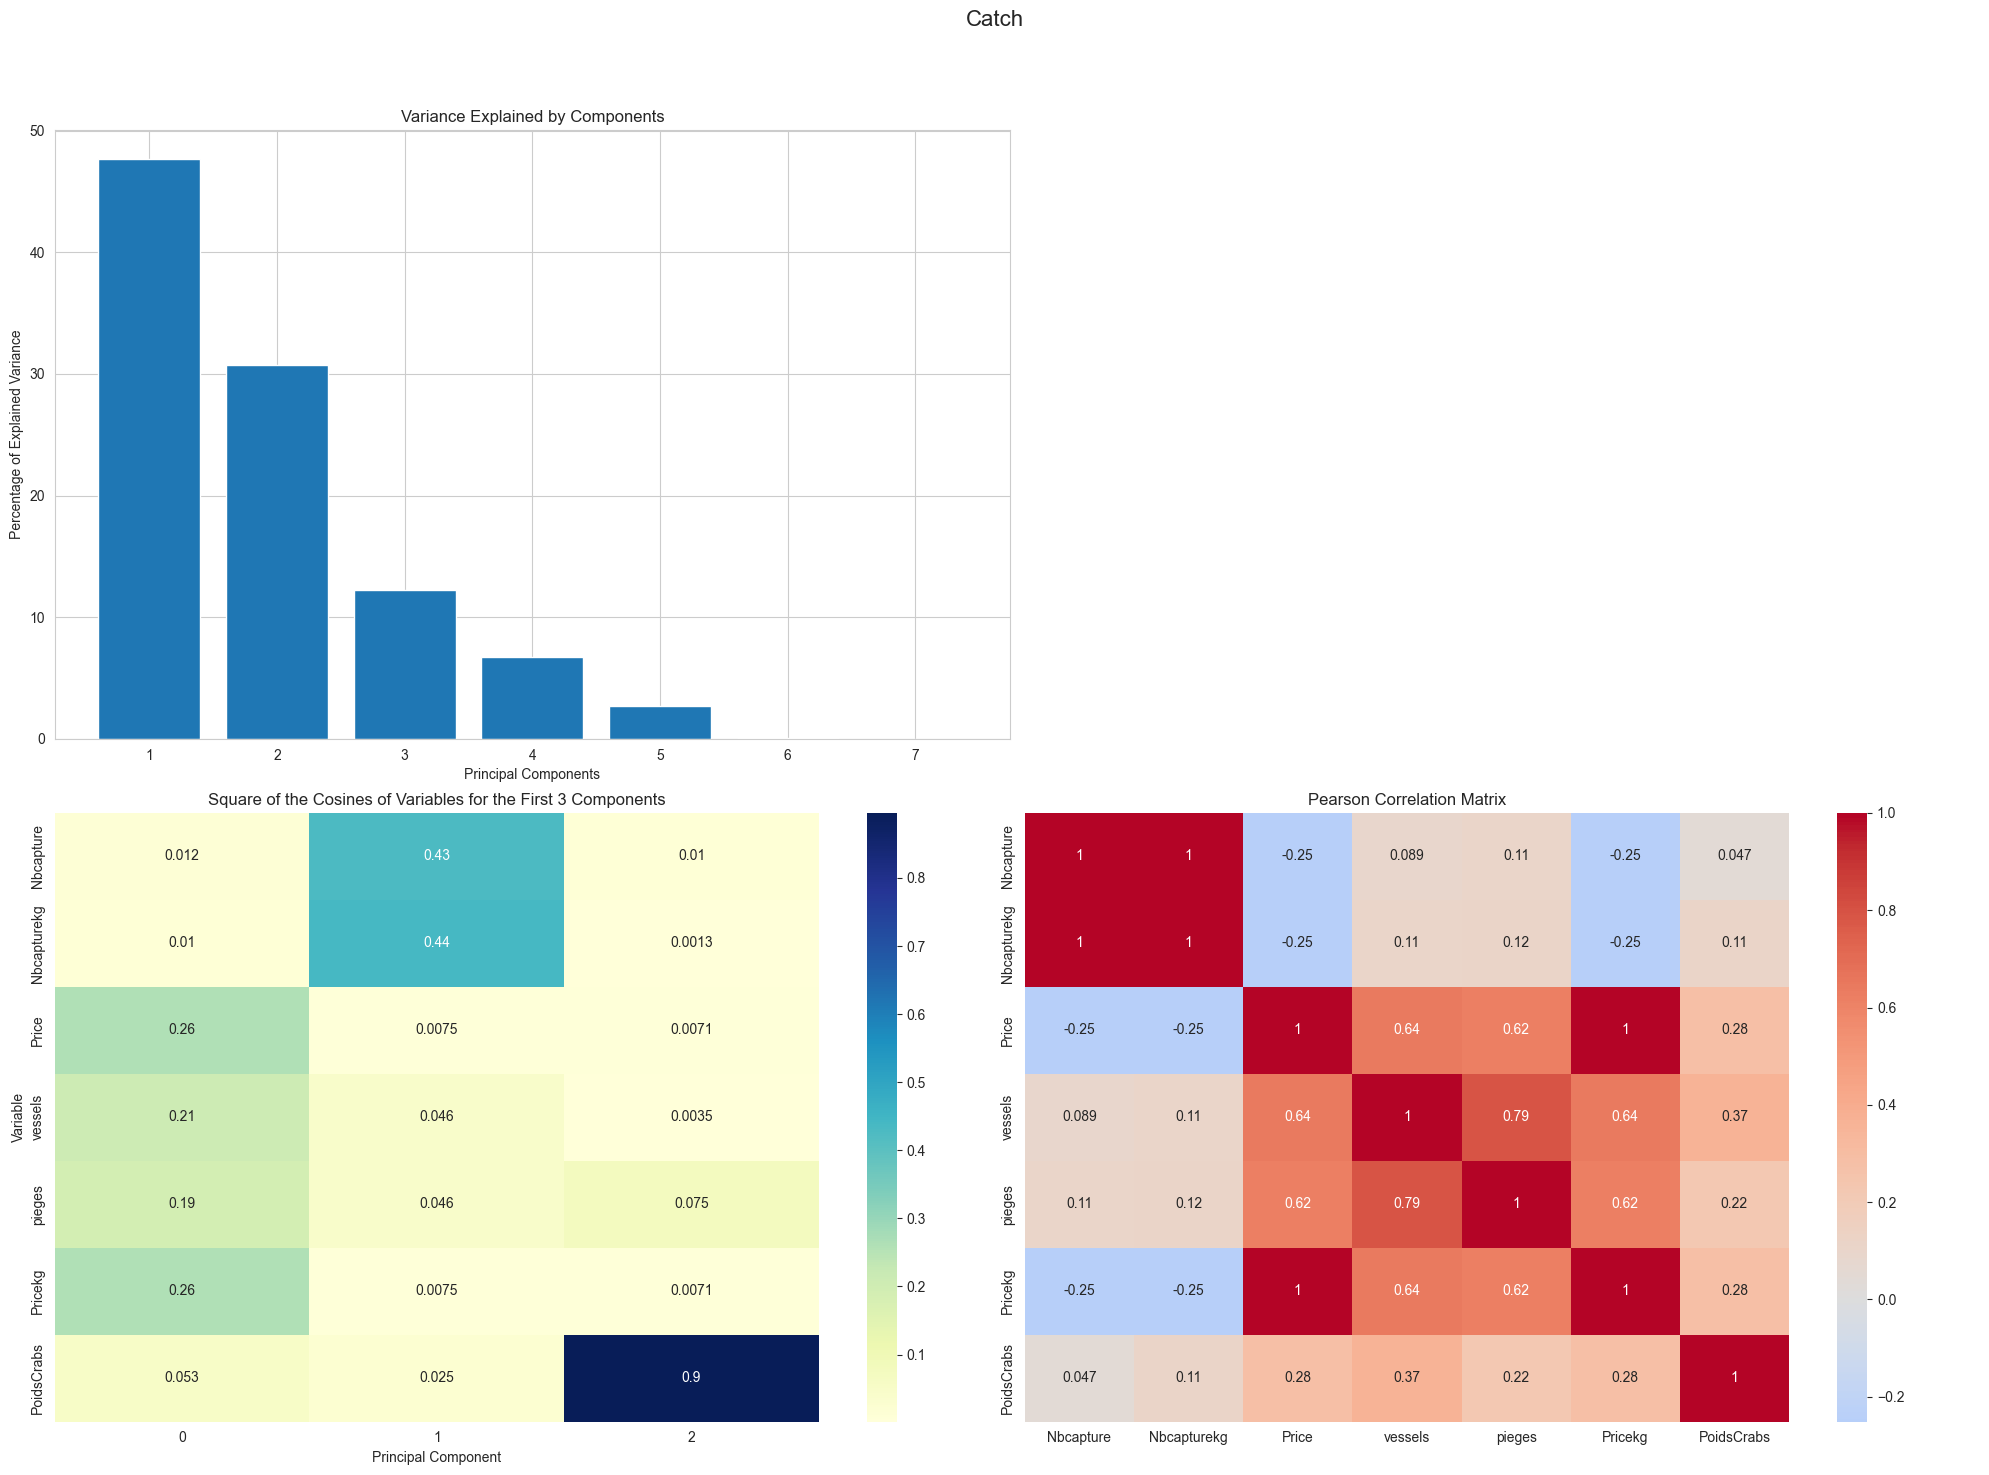

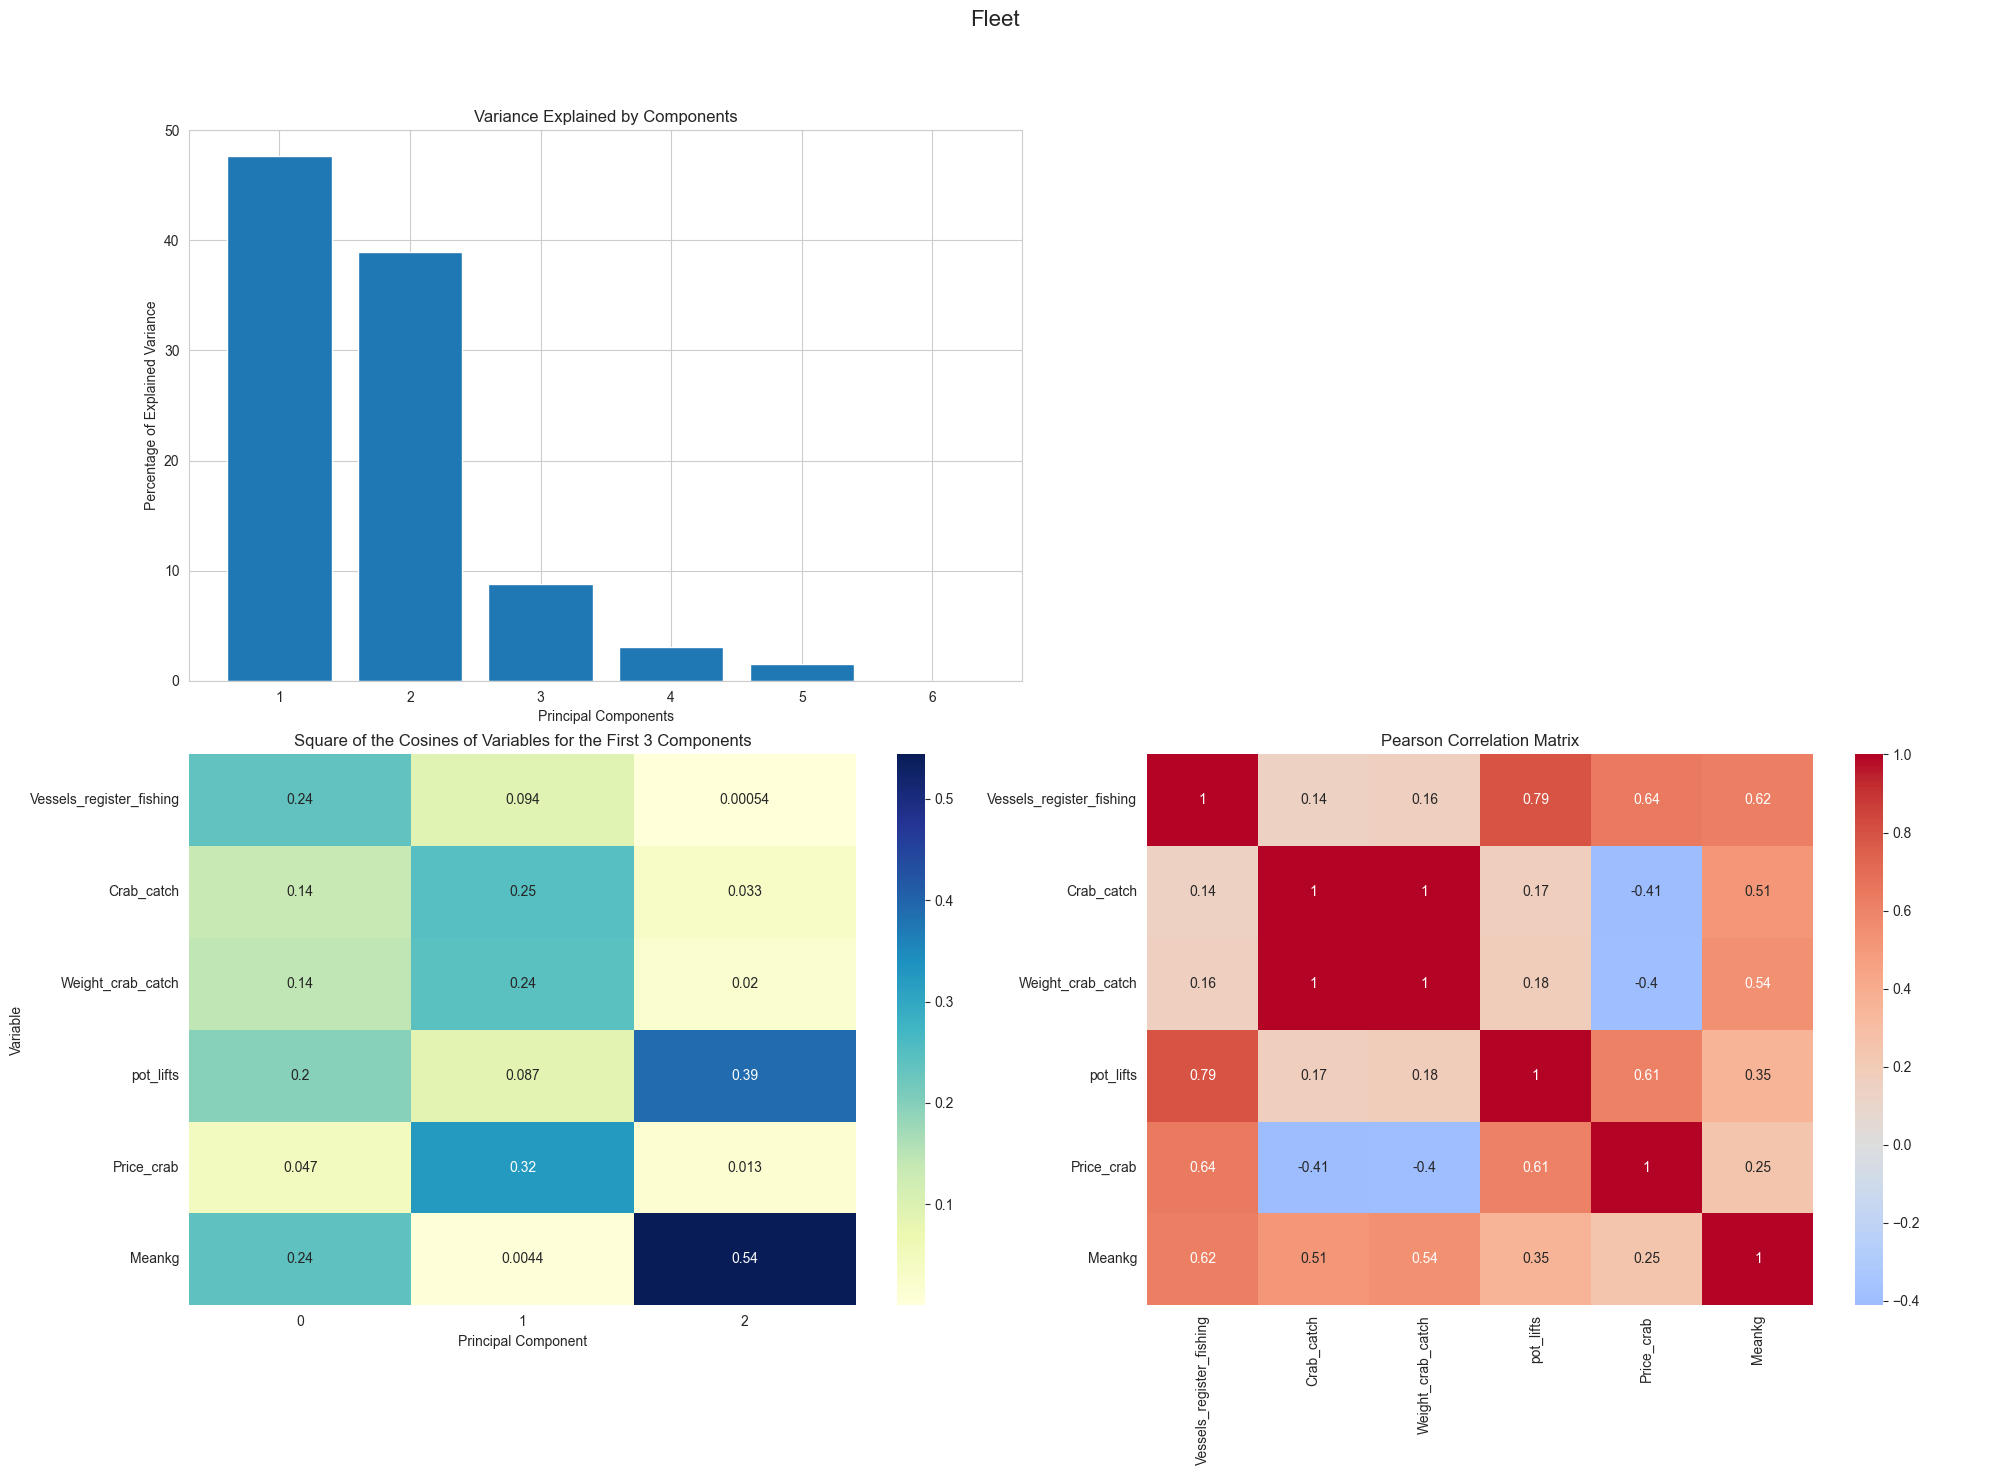

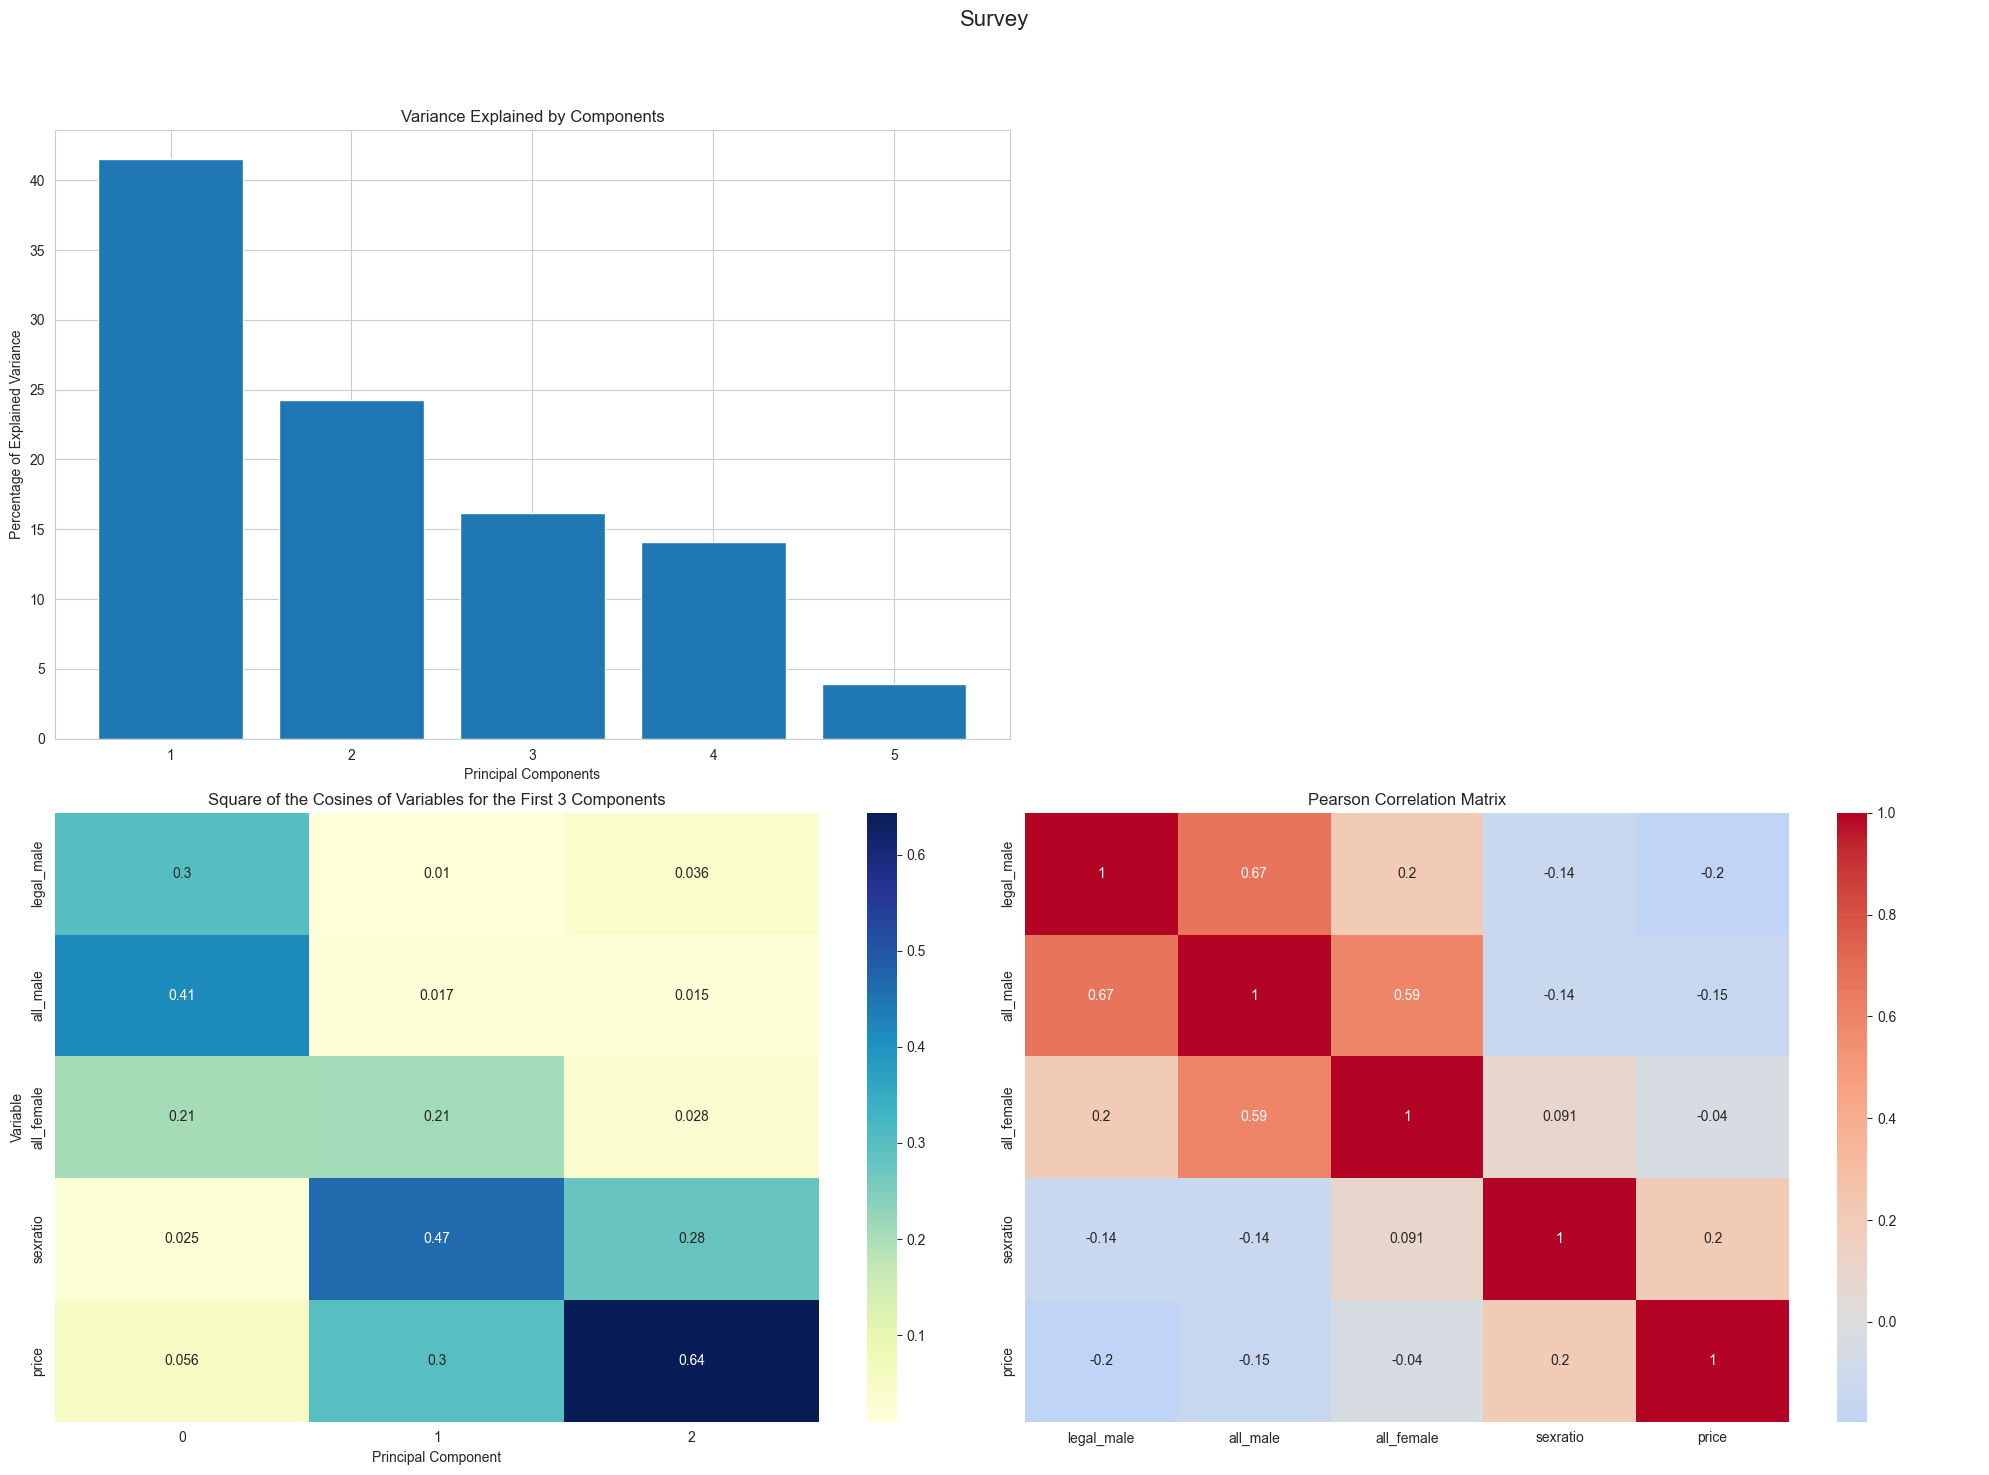

In [10]:
def perform_PCA(data, title) :
    # Check for infinite values
    data = data.copy() # Avoids a warning message from pandas
    data.replace([np.inf, -np.inf], np.nan, inplace = True)
    # Remove NaNs
    data = data.dropna()
    data_scale = StandardScaler().fit_transform(data)
    pca_model = PCA()
    pca = pca_model.fit_transform(data_scale)

    # Eigenvalues
    eigenvalues = pca_model.explained_variance_ratio_ * 100

    fig, axs = plt.subplots(2, 2, figsize=(20, 15))
    fig.suptitle(title, fontsize=16)

    axs[0, 0].bar(range(1, len(eigenvalues) + 1), eigenvalues)
    axs[0, 0].set_xlabel('Principal Components')
    axs[0, 0].set_ylabel('Percentage of Explained Variance')
    axs[0, 0].set_title('Variance Explained by Components')
    axs[0, 1].axis('off')

    cos2_vars = (pca_model.components_**2).T

    # Heatmap of cos2
    sns.heatmap(cos2_vars[:, :3], annot=True, cmap="YlGnBu", yticklabels=data.columns, ax=axs[1, 0])
    axs[1, 0].set_xlabel('Principal Component')
    axs[1, 0].set_ylabel('Variable')
    axs[1, 0].set_title('Square of the Cosines of Variables for the First 3 Components')

    correlation_df = pd.DataFrame(data_scale)
    correlation_matrix = correlation_df.corr(method='pearson')

    # Pearson Correlation Heatmap
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, xticklabels=data.columns, yticklabels=data.columns, ax=axs[1, 1])
    axs[1, 1].set_title("Pearson Correlation Matrix")
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

perform_PCA(catch.iloc[:, 2:9], "Catch")
perform_PCA(fleet.iloc[:, 1:7], "Fleet")
survey_pca = survey[['legal_male','all_male','all_female','sexratio','price']]
perform_PCA(survey_pca, "Survey")


In [11]:
def plot_diagnostiques(mod):
  # Diagnostic Plots
  # Residuals vs Fitted Values
  fig, axes = plt.subplots(2, 2, figsize=(14, 10))
  axes[0, 0].scatter(mod.fittedvalues, mod.resid_pearson, alpha=0.5)
  axes[0, 0].axhline(0, color='red')
  axes[0, 0].set_xlabel('Predicted Values')
  axes[0, 0].set_ylabel('Standardized Residuals')
  axes[0, 0].set_title('Residuals vs. Predicted Values')

  # Histogram of Residuals
  axes[0, 1].hist(mod.resid_pearson, bins=50, edgecolor='k', alpha=0.7)
  axes[0, 1].set_xlabel('Standardized Residuals')
  axes[0, 1].set_title('Histogram of Residuals')

  # Q-Q Plot of Residuals
  qqplot(mod.resid_pearson, line='45', fit=True, ax=axes[1, 0])
  axes[1, 0].set_title('Q-Q Plot of Residuals')

  axes[1, 1].axis('off')

  plt.tight_layout()
  plt.show()


                            OLS Regression Results                            
Dep. Variable:         Meanprice1crab   R-squared:                       0.501
Model:                            OLS   Adj. R-squared:                  0.495
Method:                 Least Squares   F-statistic:                     94.29
Date:                Sun, 26 Nov 2023   Prob (F-statistic):           7.59e-16
Time:                        15:44:09   Log-Likelihood:                -301.54
No. Observations:                  96   AIC:                             607.1
Df Residuals:                      94   BIC:                             612.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -55.1647      6.322     -8.726      0.0

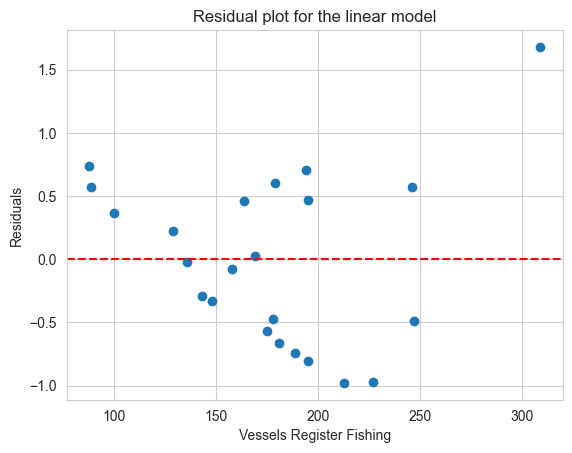

                            OLS Regression Results                            
Dep. Variable:               logprice   R-squared:                       0.691
Model:                            OLS   Adj. R-squared:                  0.642
Method:                 Least Squares   F-statistic:                     14.16
Date:                Sun, 26 Nov 2023   Prob (F-statistic):           4.38e-05
Time:                        15:44:09   Log-Likelihood:                -21.525
No. Observations:                  23   AIC:                             51.05
Df Residuals:                      19   BIC:                             55.59
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

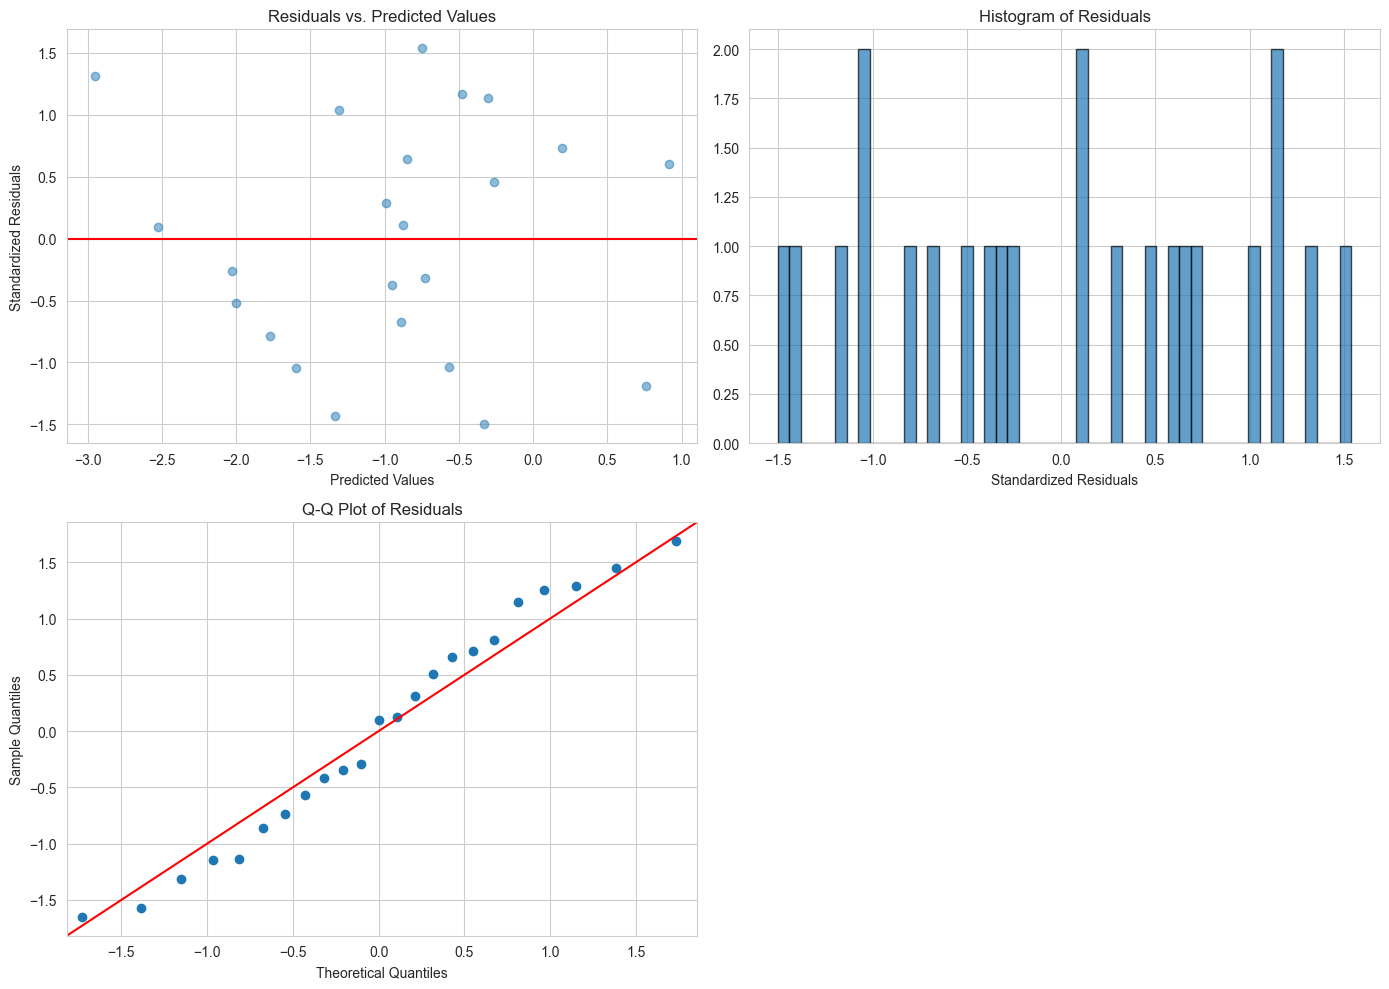

In [12]:
#### Evolution and modeling the price of Red King Crab between 1960 and 1982:
### Average Price ~ Year
X = sm.add_constant(catch['annee'])
y = catch['Meanprice1crab']
mod_prix1crab1 = sm.OLS(y, X).fit()
print(mod_prix1crab1.summary())
# AIC: 607.1 year 0.8594 P>|t| 0.000

### Price ~ Number of Boats
X = sm.add_constant(fleet['Vessels_register_fishing'])
y = fleet['Price_crab']
modprix = sm.OLS(y, X).fit()
print(modprix.summary())

# Plot of Residuals
plt.scatter(fleet['Vessels_register_fishing'], modprix.resid)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Vessels Register Fishing')
plt.ylabel('Residuals')
plt.title('Residual plot for the linear model')
plt.show()
# Heteroscedasticity

### log(Price) ~ Number of boats + catch + average weight (kg)
X = sm.add_constant(fleet[['Vessels_register_fishing', 'Crab_catch', 'Meankg']])
y = fleet['logprice']
modprixlog = sm.OLS(y, X).fit()
print(modprixlog.summary())

plot_diagnostiques(modprixlog)


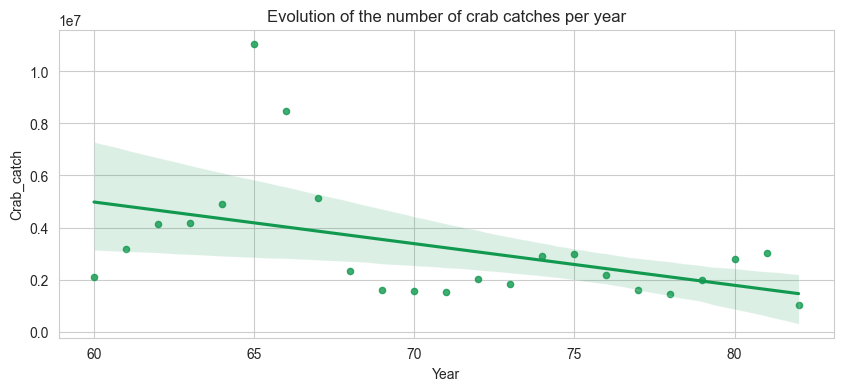

1048542.4936920922
                 Generalized Linear Model Regression Results                  
Dep. Variable:             Crab_catch   No. Observations:                   23
Model:                            GLM   Df Residuals:                       21
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -366.31
Date:                Sun, 26 Nov 2023   Deviance:                       5.7685
Time:                        15:44:09   Pearson chi2:                     6.95
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1110
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         18.6625      2.242 

c:\Users\Windows\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


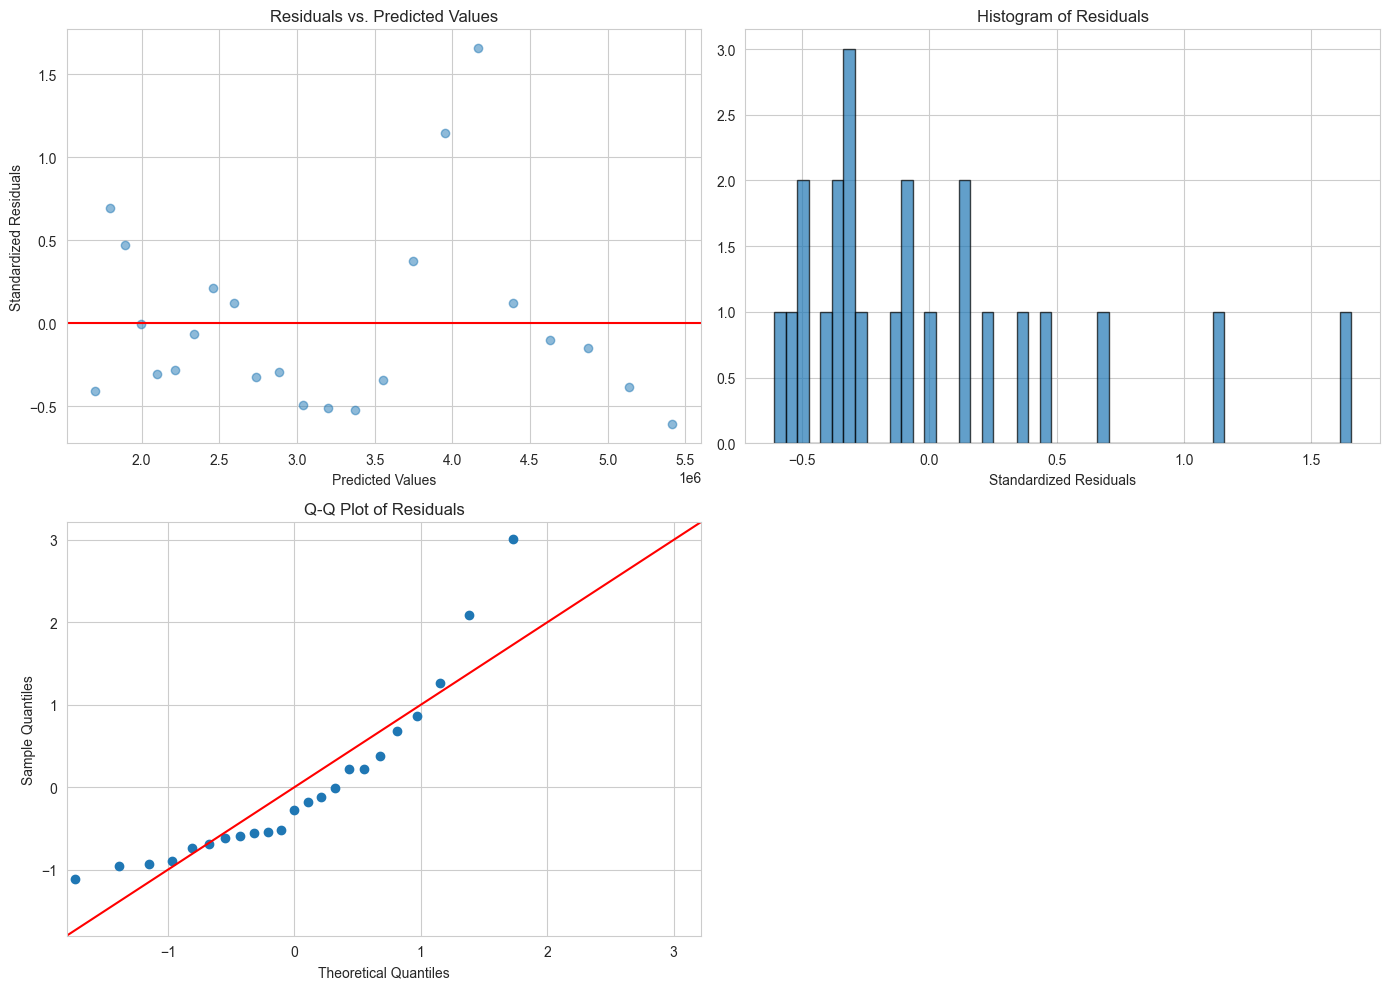

In [13]:
#### Evolution of fishing around the Kodiak Islands:
## Modeling number of catches
plt.figure(figsize=(10, 4))
sns.regplot(data=fleet, x='Year', y='Crab_catch', color='#129950', scatter_kws={'s':20})
plt.xlabel("Year")
plt.ylabel("Crab_catch")
plt.title("Evolution of the number of crab catches per year")
plt.show()
# Downward trend

X = sm.add_constant(fleet['Year'])
Y = fleet['Crab_catch']
mod_crabcatch = sm.GLM(Y,X, family = sm.families.Poisson()).fit()
# Calculation of dispersion
dispersion = mod_crabcatch.deviance / mod_crabcatch.df_resid
# High dispersion
print(dispersion)

# Negative binomial model
mod_crabcatch_nb = sm.GLM(Y, X, family=sm.families.NegativeBinomial()).fit()
print(mod_crabcatch_nb.summary())

plot_diagnostiques(mod_crabcatch_nb)


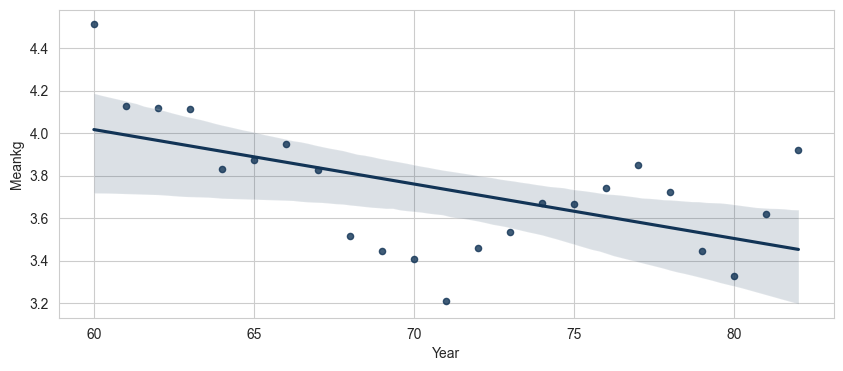

                            OLS Regression Results                            
Dep. Variable:                 Meankg   R-squared:                       0.319
Model:                            OLS   Adj. R-squared:                  0.287
Method:                 Least Squares   F-statistic:                     9.839
Date:                Sun, 26 Nov 2023   Prob (F-statistic):            0.00498
Time:                        15:44:10   Log-Likelihood:               -0.59464
No. Observations:                  23   AIC:                             5.189
Df Residuals:                      21   BIC:                             7.460
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.5542      0.583      9.535      0.0

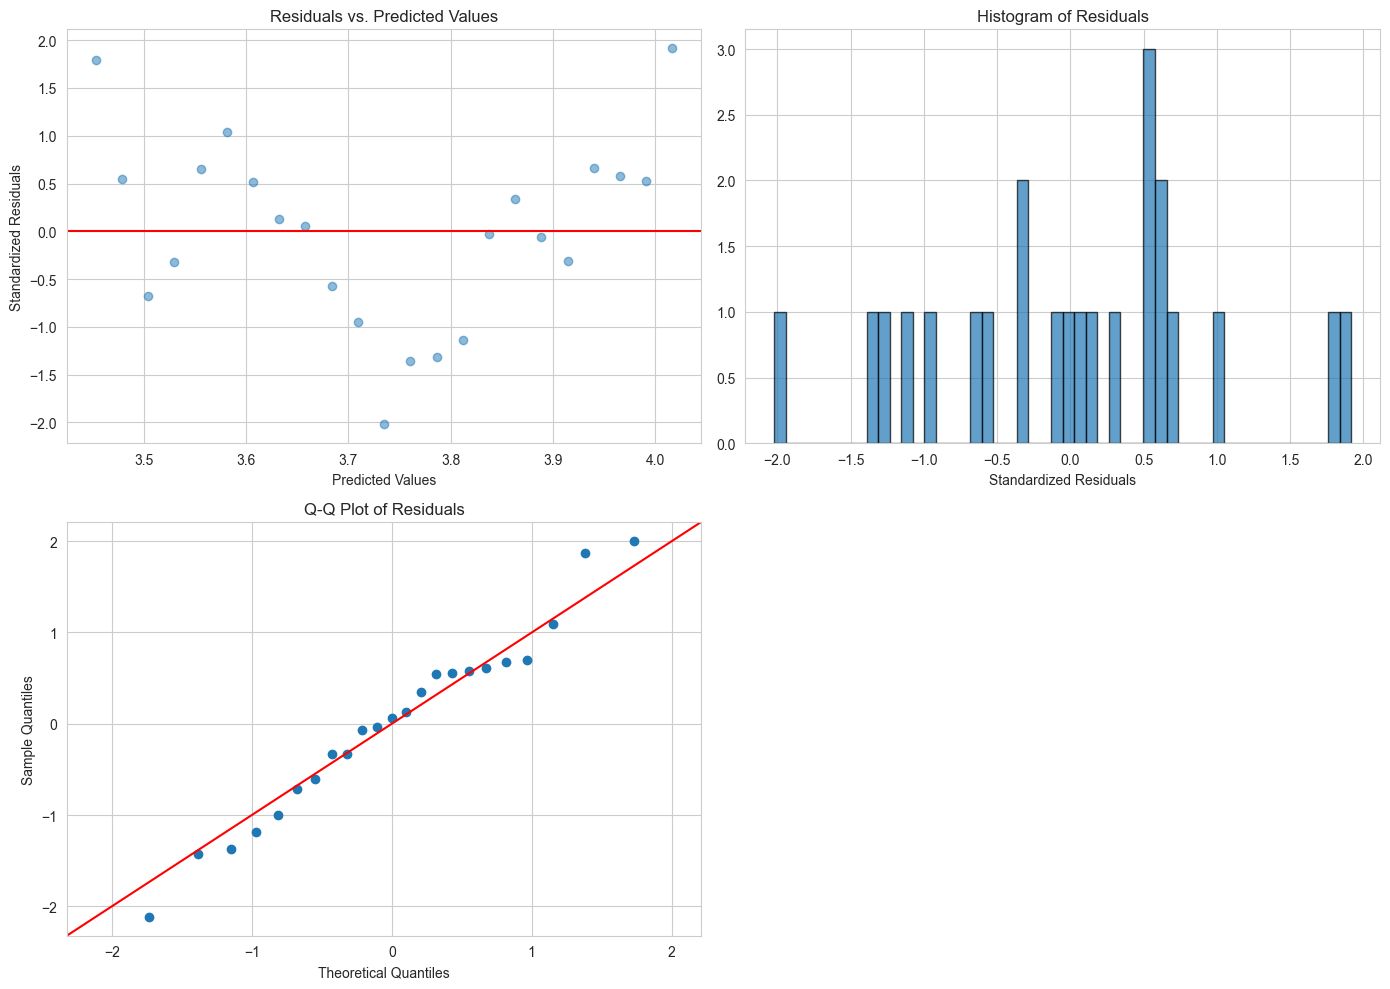

In [14]:
# Modeling average weight
plt.figure(figsize=(10, 4))
sns.regplot(data=fleet, x='Year', y='Meankg', color='#123456', scatter_kws={'s':20})
plt.xlabel('Year')
plt.ylabel('Meankg')
plt.show()
# Downward trend

X = sm.add_constant(fleet["Year"])
Y = fleet['Meankg']
mod_poidsmoyen = sm.OLS(Y,X).fit()
print(mod_poidsmoyen.summary())

plot_diagnostiques(mod_poidsmoyen)


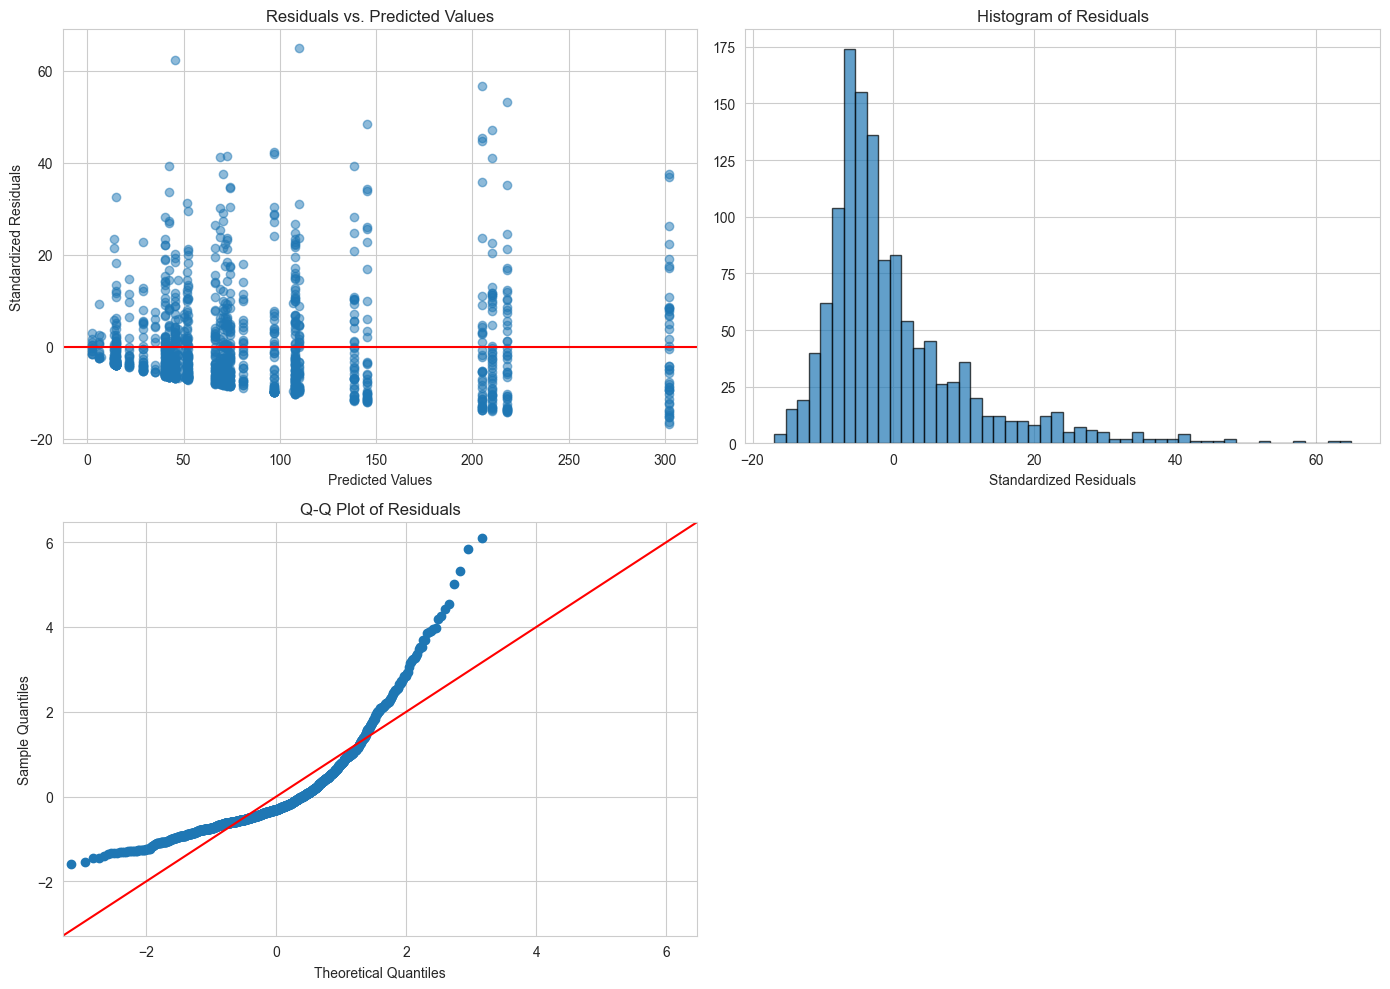

                 Generalized Linear Model Regression Results                  
Dep. Variable:             legal_male   No. Observations:                 1252
Model:                            GLM   Df Residuals:                     1218
Model Family:                 Poisson   Df Model:                           33
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -62938.
Date:                Sun, 26 Nov 2023   Deviance:                   1.1950e+05
Time:                        15:44:11   Pearson chi2:                 1.42e+05
No. Iterations:                   100   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

In [15]:
#### Evolution of the abundance of MALE crabs available for fishing:
# Removing the year 1973 because the abundance is already abnormally low, so we don't want to take it as a reference in our model
survey_no73 = survey[survey['annee'] != 73]
survey_no73 = survey_no73.copy()
survey_no73['district'] = survey_no73['district'].astype('category')
survey_no73['annee'] = survey_no73['annee'].astype('category')
survey_no73 = survey_no73.dropna()
survey_no73 = survey_no73.replace([float('inf'), -float('inf')], np.nan).dropna()

formula = 'legal_male ~ annee + district + annee:district'
mod_legal_male = smf.glm(formula = formula, data = survey_no73, family=sm.families.Poisson()).fit()
plot_diagnostiques(mod_legal_male)
print(mod_legal_male.summary())



                            OLS Regression Results                            
Dep. Variable:              legalmale   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     9.985
Date:                Sun, 26 Nov 2023   Prob (F-statistic):             0.0123
Time:                        15:44:11   Log-Likelihood:                -101.27
No. Observations:                  11   AIC:                             214.5
Df Residuals:                       5   BIC:                             216.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.743e+05   4.47e+05      1.958      0.1

c:\Users\Windows\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


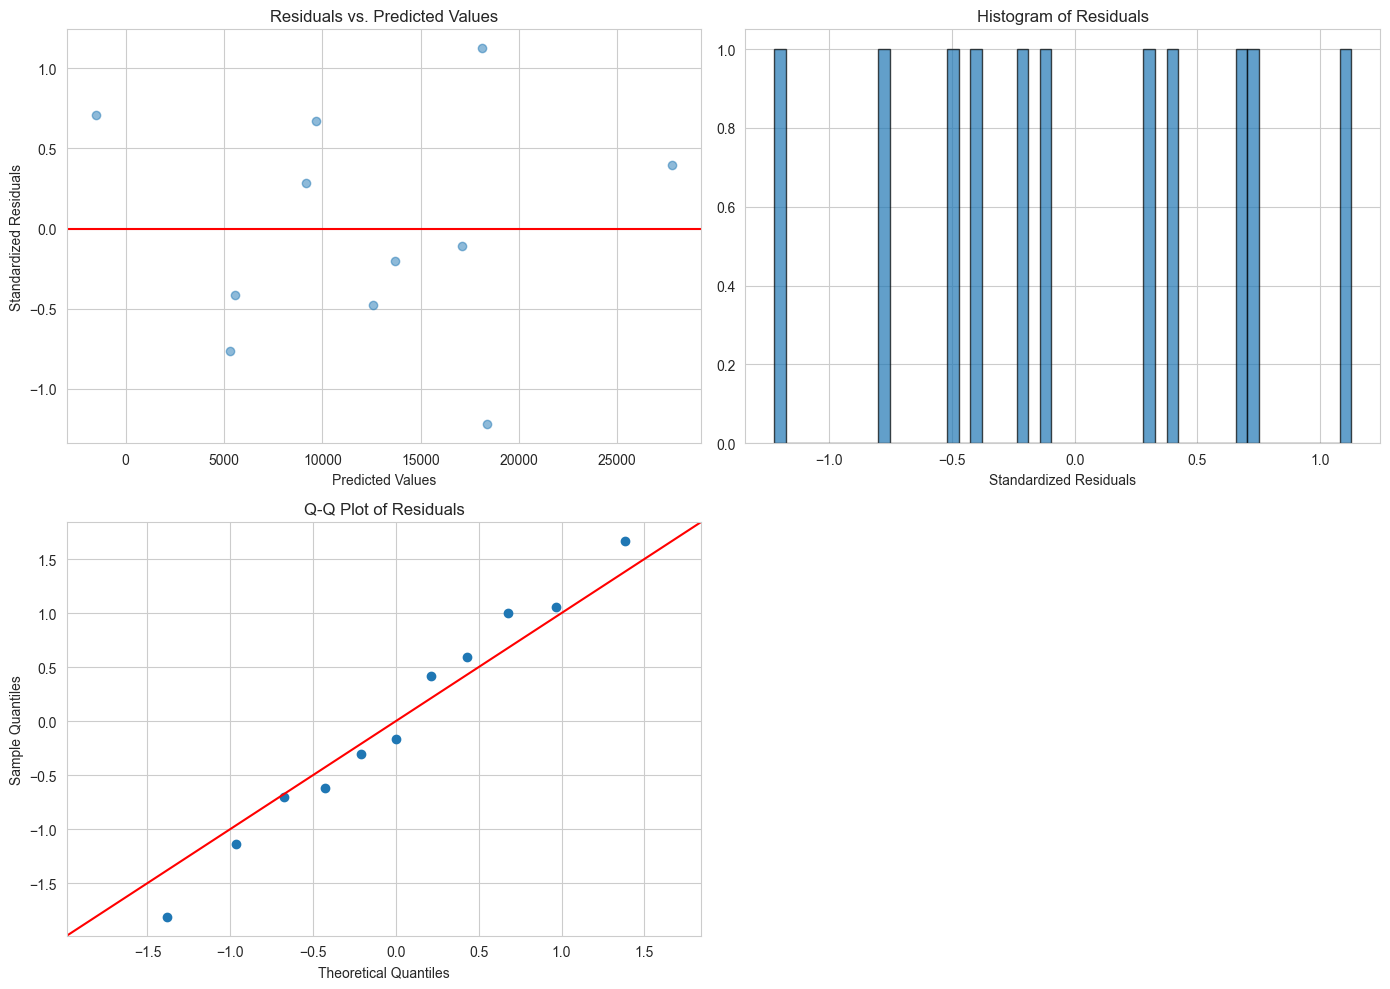

['Year', 'salinity', 'temp', 'meansex', 'full', 'f29']


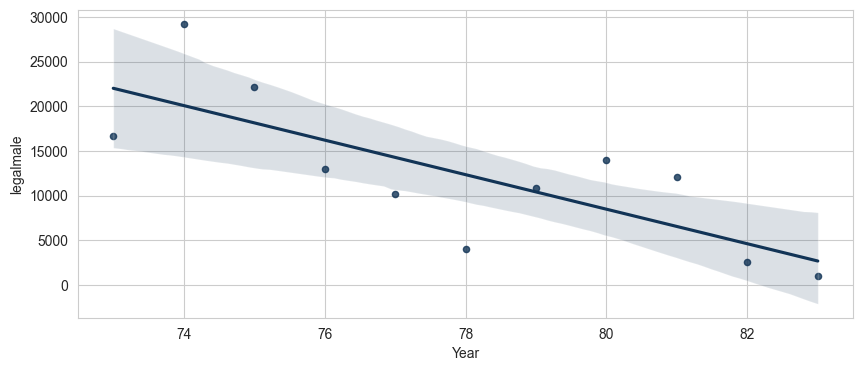

Year-0.7646867643492756


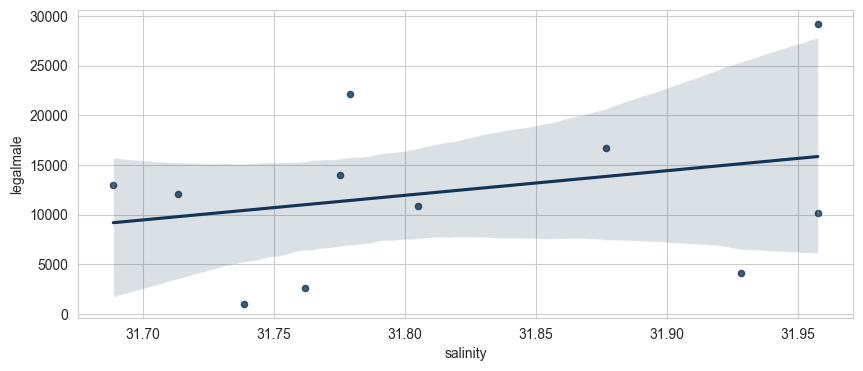

salinity0.2887051431317118


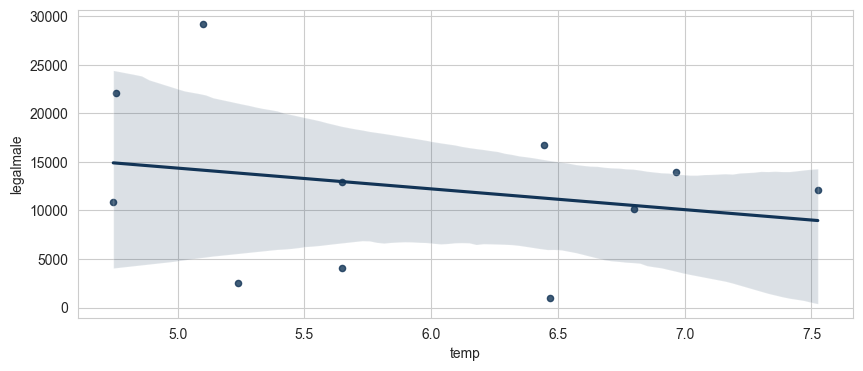

temp-0.24236574078508727


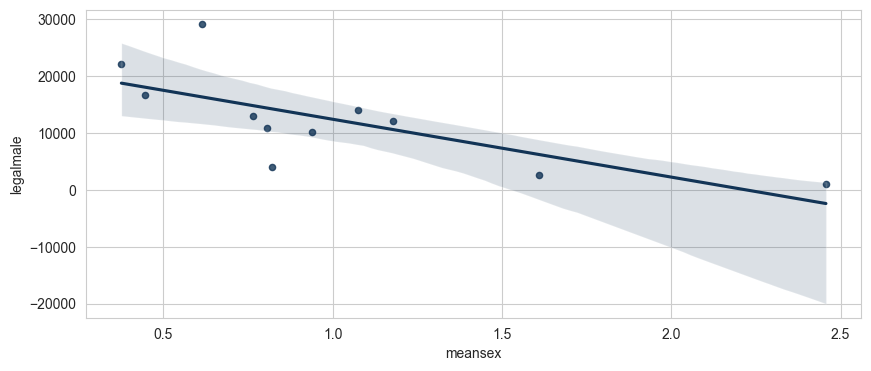

meansex-0.7192472783515695


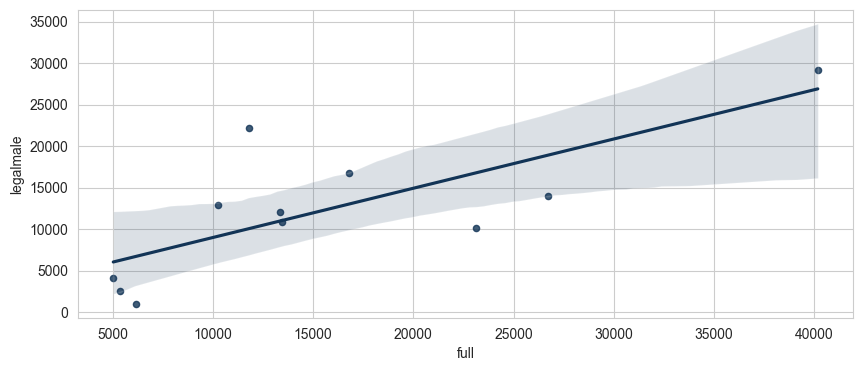

full0.7579550949969942


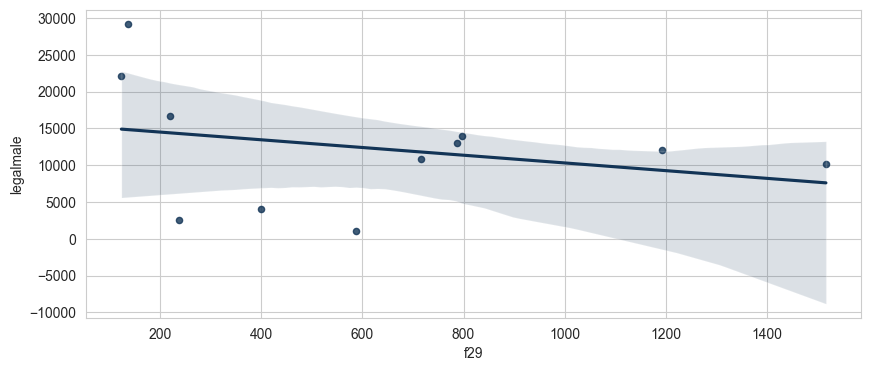

f29-0.28238078851965603
                            OLS Regression Results                            
Dep. Variable:              legalmale   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     7.295
Date:                Sun, 26 Nov 2023   Prob (F-statistic):             0.0653
Time:                        15:44:12   Log-Likelihood:                -98.546
No. Observations:                  11   AIC:                             213.1
Df Residuals:                       3   BIC:                             216.3
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          2.433e+

c:\Users\Windows\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


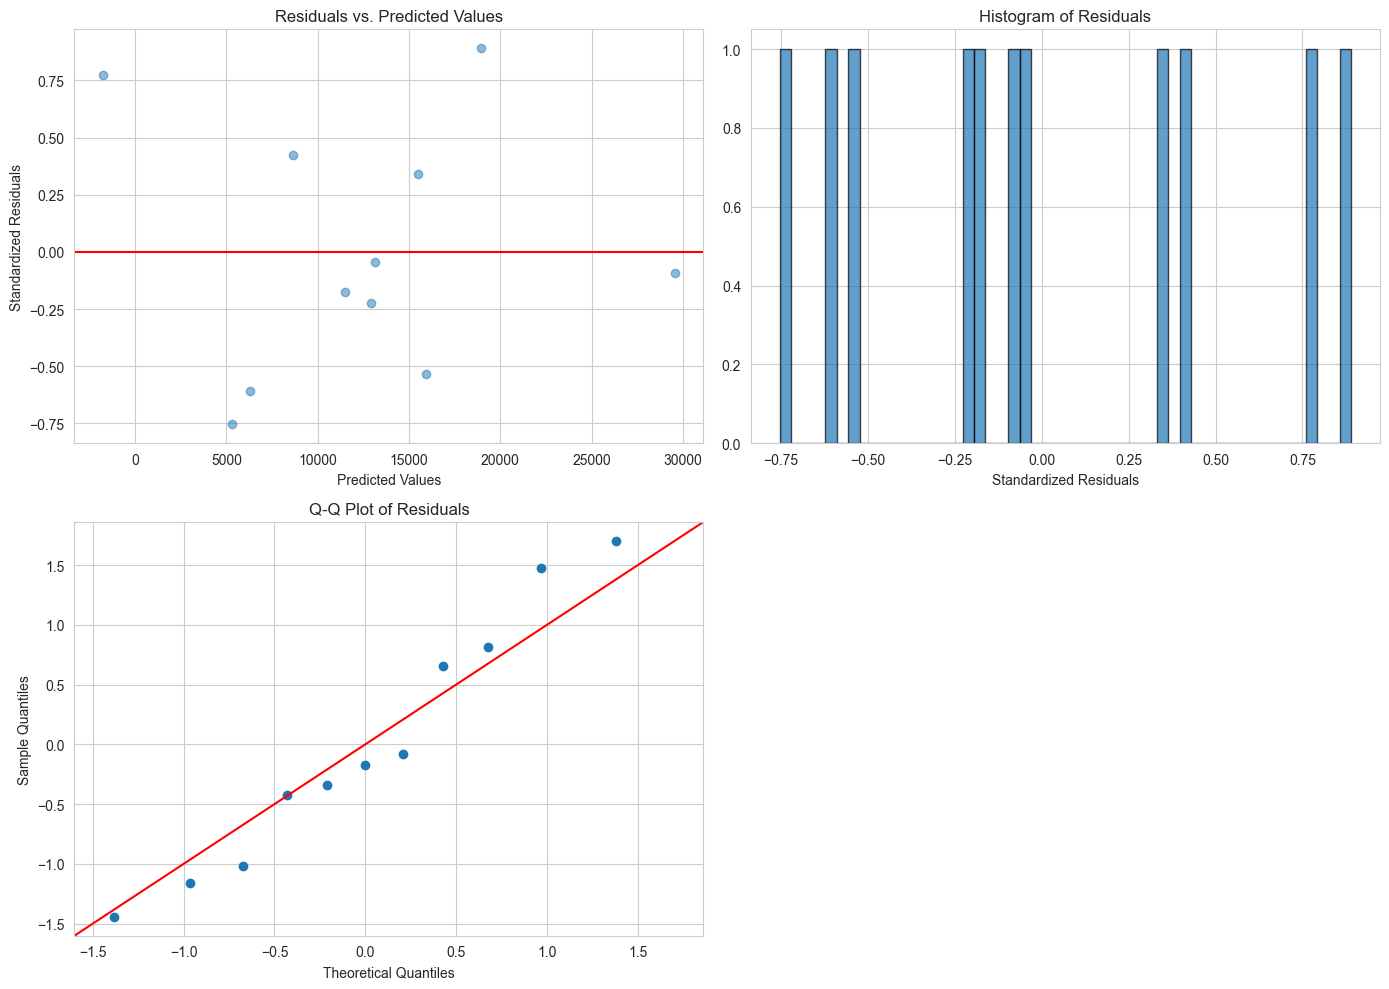

In [16]:
#### Modeling the abundance of legally fishable crabs:
# Average number of legally catchable crabs
meanlegal = survey.groupby('annee').agg({'legal_male': 'sum'}).reset_index()
# Average salinity
meansalinity = salinite.groupby('annee').agg({'salinite': 'mean'}).reset_index()
# Average fullness 90-100%
meanfull = fullness.groupby('Year').agg({'90-100%_fullness': 'sum'}).reset_index()
# Average 1-29% fullness
mean29 = fullness.groupby('Year').agg({'1-29%_fullness': 'sum'}).reset_index()

survey2 = meansalinity.copy()
survey2.columns = ['Year', 'salinity']

survey2['temp'] = meanTemp['temp'][:14].values
# Number of mals
Nbmale = survey.groupby('annee').agg({'all_male': 'sum'}).reset_index()
# Number of females
Nbfemale = survey.groupby('annee').agg({'all_female': 'sum'}).reset_index()
survey2 = survey2.iloc[3:].reset_index(drop=True)
# Survey2
survey2['meansex'] = Nbfemale['all_female'][:11].values / Nbmale['all_male'][:11].values
survey2['full'] = meanfull['90-100%_fullness'][:11].values
survey2['f29'] = mean29['1-29%_fullness'][:11].values
survey2['legalmale'] = meanlegal['legal_male'][:11].values
# Model for the abundance of legally catchable males
X = sm.add_constant(survey2[['full', 'f29', 'meansex', 'temp', 'salinity']])
Y = survey2['legalmale']

mod_legal_male = sm.OLS(Y,X).fit()
print(mod_legal_male.summary())

plot_diagnostiques(mod_legal_male)

survey2_variables = [col for col in survey2.columns if col != "legalmale"]
print(survey2_variables)

for variable in survey2_variables :
  plt.figure(figsize=(10, 4))
  sns.regplot(data=survey2, x=variable, y='legalmale', color='#123456', scatter_kws={'s':20})
  plt.xlabel(variable)
  plt.ylabel('legalmale')
  plt.show()
  correlation = survey2['legalmale'].corr(survey2[variable])
  print(variable +  str(correlation))

# Salinity, temperature, and f29 are non-linear.
# Adding quadratic terms for salinity and temperature

survey2["temp_sqrt"] = survey2["temp"]**2
survey2["salinity_sqrt"] = survey2["salinity"]**2


X = sm.add_constant(survey2[['full', 'f29','meansex', 'temp', 'salinity', 'temp_sqrt', 'salinity_sqrt']])
Y = survey2['legalmale']

mod_legal_male_2 = sm.OLS(Y, X).fit()
print(mod_legal_male_2.summary())
plot_diagnostiques(mod_legal_male_2)
# Full has a significant effect on the abundance of legally fishable crabs


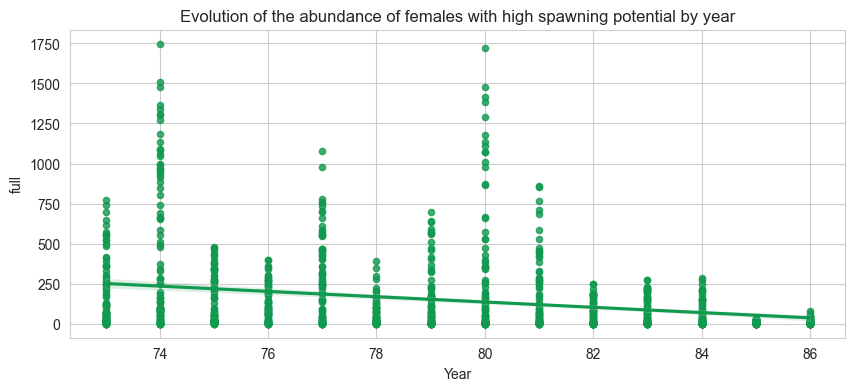

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   full   No. Observations:                 1170
Model:                            GLM   Df Residuals:                     1155
Model Family:                 Poisson   Df Model:                           14
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.0056e+05
Date:                Sun, 26 Nov 2023   Deviance:                   1.9506e+05
Time:                        15:44:13   Pearson chi2:                 1.95e+05
No. Iterations:                     7   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         7.7893      0.014    553.253

c:\Users\Windows\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


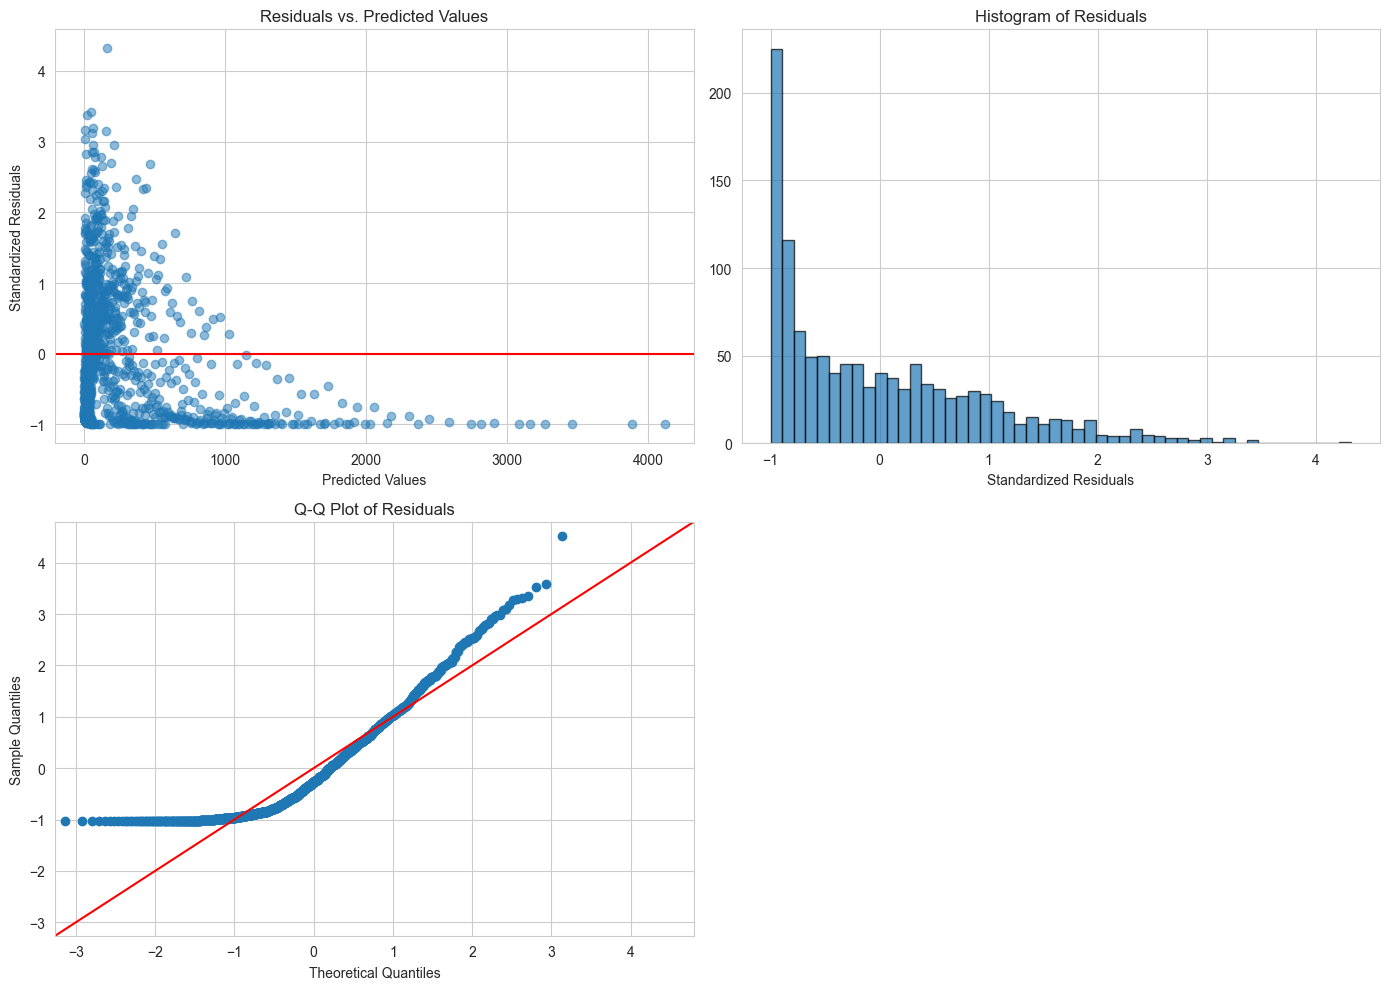

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   full   No. Observations:                 1170
Model:                            GLM   Df Residuals:                     1155
Model Family:        NegativeBinomial   Df Model:                           14
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -6269.0
Date:                Sun, 26 Nov 2023   Deviance:                       2150.8
Time:                        15:44:13   Pearson chi2:                 1.07e+03
No. Iterations:                    28   Pseudo R-squ. (CS):             0.7385
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        12.5649      0.192     65.375

In [17]:
#### Evolution of the abundance of females with high spawning potential:
fullness['Year'] = fullness['Year'].astype('category')
fullness.columns = ['Year', 'Size','0','1-29','30-59','60-89','full']
fullness['Year'] = fullness['Year'].cat.as_ordered()

formula = 'full ~ C(Year) + Size'

plt.figure(figsize=(10, 4))
sns.regplot(data=fullness, x='Year', y='full', color='#129950', scatter_kws={'s':20})
plt.xlabel("Year")
plt.ylabel("full")
plt.title("Evolution of the abundance of females with high spawning potential by year")
plt.show()

mod_fullness = smf.glm(formula=formula, data=fullness, family=sm.families.Poisson()).fit()
print(mod_fullness.summary())

dispersion = mod_fullness.deviance / mod_fullness.df_resid
print(dispersion)
# High dispersion

mod_fullness = smf.glm(formula=formula, data=fullness, family=sm.families.NegativeBinomial()).fit()
plot_diagnostiques(mod_fullness)
print(mod_fullness.summary())